In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import os, os.path as path

from spectrum import FitsSpectrum
from common import list_files, list_directories, tqdm

In [2]:
dib_centers_all = np.array([float(path.basename(dib_file).replace('.ascii', '')) for dib_file in list_files('data/dibs')])
dib_centers_subset = [5780,5797,6196,6379,6613,7224]

def load_target(target_dir: str) -> list[FitsSpectrum]:
    return [FitsSpectrum(datafile) for band_dir in list_directories(target_dir) for datafile in list_files(band_dir)]

def fit_gaussian_for_subspectrum(
    subspectrum: FitsSpectrum,
    create_figure = False,
    export_data: list | None = None,
    table_data: list | None = None,
    dib_slice: tuple[int, int] | None = None,
    expected_dib_centers: np.typing.NDArray | None = None,
    tqdm_position: int = 0,
    show_error = False
):
    wvl_max, wvl_min = np.max(subspectrum.wavelength), np.min(subspectrum.wavelength)

    subspectrum.remove_outliers()
    subspectrum.correct_shift()

    dibs = list(subspectrum.select_dibs().items())
    dibs_tqdm = tqdm(dibs if dib_slice is None else dibs[dib_slice[0]:dib_slice[1]], position=tqdm_position)
    for center, bounds in dibs_tqdm:
        dibs_tqdm.set_description(f'λ={wvl_min:.2f}-{wvl_max:.2f} [{center:.2f}]')

        # The DIB does not lie in this subspectrum or is not an expected DIB (within 2 angstrom)
        if not wvl_min < center < wvl_max or (expected_dib_centers is not None and np.all(np.abs(expected_dib_centers - center) > 0.5)):
            continue

        ax = None
        if create_figure:
            _, ax = plt.subplots(1, 1, figsize=(15, 12))

        result = subspectrum.fit_gaussian(center, bounds, ax=ax, show_error=show_error)

        if result is None:
            continue

        params, rmse, fwhm, ew = result
        centers, widths, amplitudes, skews = np.column_stack(params)

        if table_data is not None:
            table_data.append([subspectrum.target, subspectrum.format_obs_date(), bounds[0], bounds[1], *np.column_stack(params), rmse, fwhm, ew])

        if export_data is not None:
            export_data.append('\t'.join([
                subspectrum.obs_date.isoformat(),
                str(bounds[0]), str(bounds[1]),
                np.array2string(centers, separator=','),
                np.array2string(amplitudes, separator=','),
                np.array2string(widths, separator=','),
                np.array2string(skews, separator=','),
                str(rmse), str(fwhm), str(ew)
            ]))


def fit_gaussian_for_targets(
    targets: list | str,
    expected_dib_centers: np.typing.NDArray | None = None,
    export = False,
    create_figure = False,
    show_error = False
):
    headers = ['Observation date', 'Start [Å]', 'End [Å]', 'Center [Å]', 'Width', 'Amplitude', 'Skew', 'RMSE', 'FWHM [Å]', 'EW [Å]']
    table_data = []

    if type(targets) == str:
        targets = [targets]

    targets_tqdm = tqdm(targets)
    for target in targets_tqdm:
        export_data = ['# ' + '\t'.join(headers)] if export else None
        subspectra = load_target(f'data/fits/{target}')
        
        for subspectrum in subspectra:
            targets_tqdm.set_description(f'{subspectrum.target} | {subspectrum.format_obs_date()}')
            fit_gaussian_for_subspectrum(subspectrum, create_figure, export_data, table_data, expected_dib_centers=expected_dib_centers, tqdm_position=1, show_error=show_error)

        if export:
            export_file = open(f'export/{target}_gaussians.csv', 'w+')
            export_file.write('\n'.join(export_data))
            export_file.close()

    return tabulate(table_data, ['Target', *headers], tablefmt='html')


In [ ]:
hd185859 = load_target('data/fits/HD185859')

sp = hd185859[1]
_ = fit_gaussian_for_subspectrum(hd185859[1], True, dib_slice=(40, 50))
# _ = fit_gaussian_for_subspectrum(hd185859[1], True, expected_dib_centers=dib_centers_all)

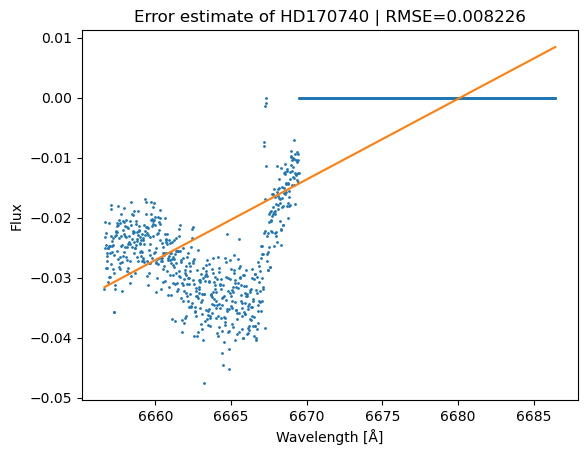

λ=5654.46-6686.46 [6654.80]: 100%|██████████| 219/219 [00:00<00:00, 313.49it/s]


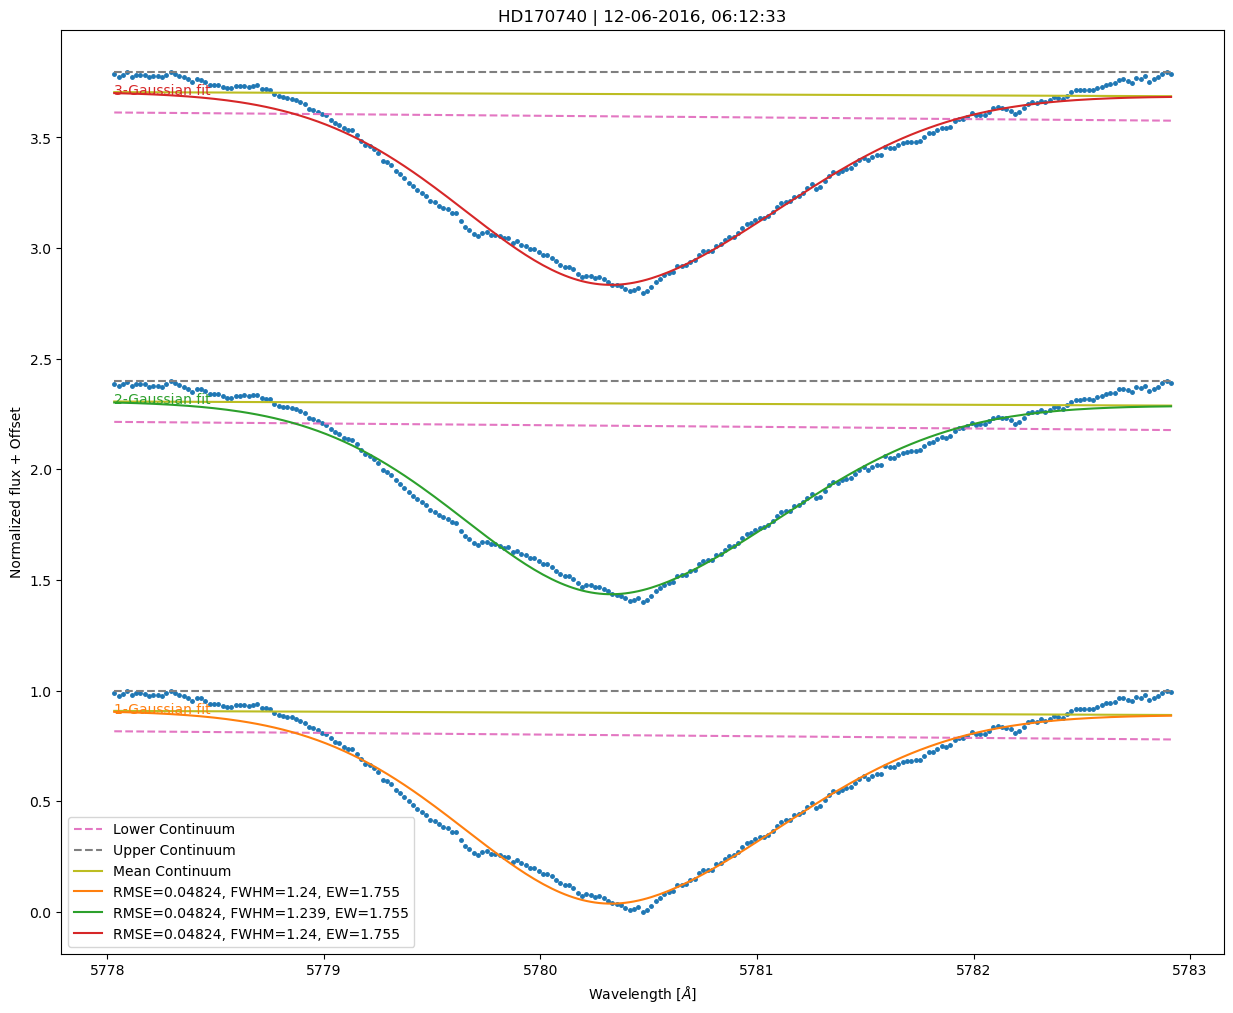

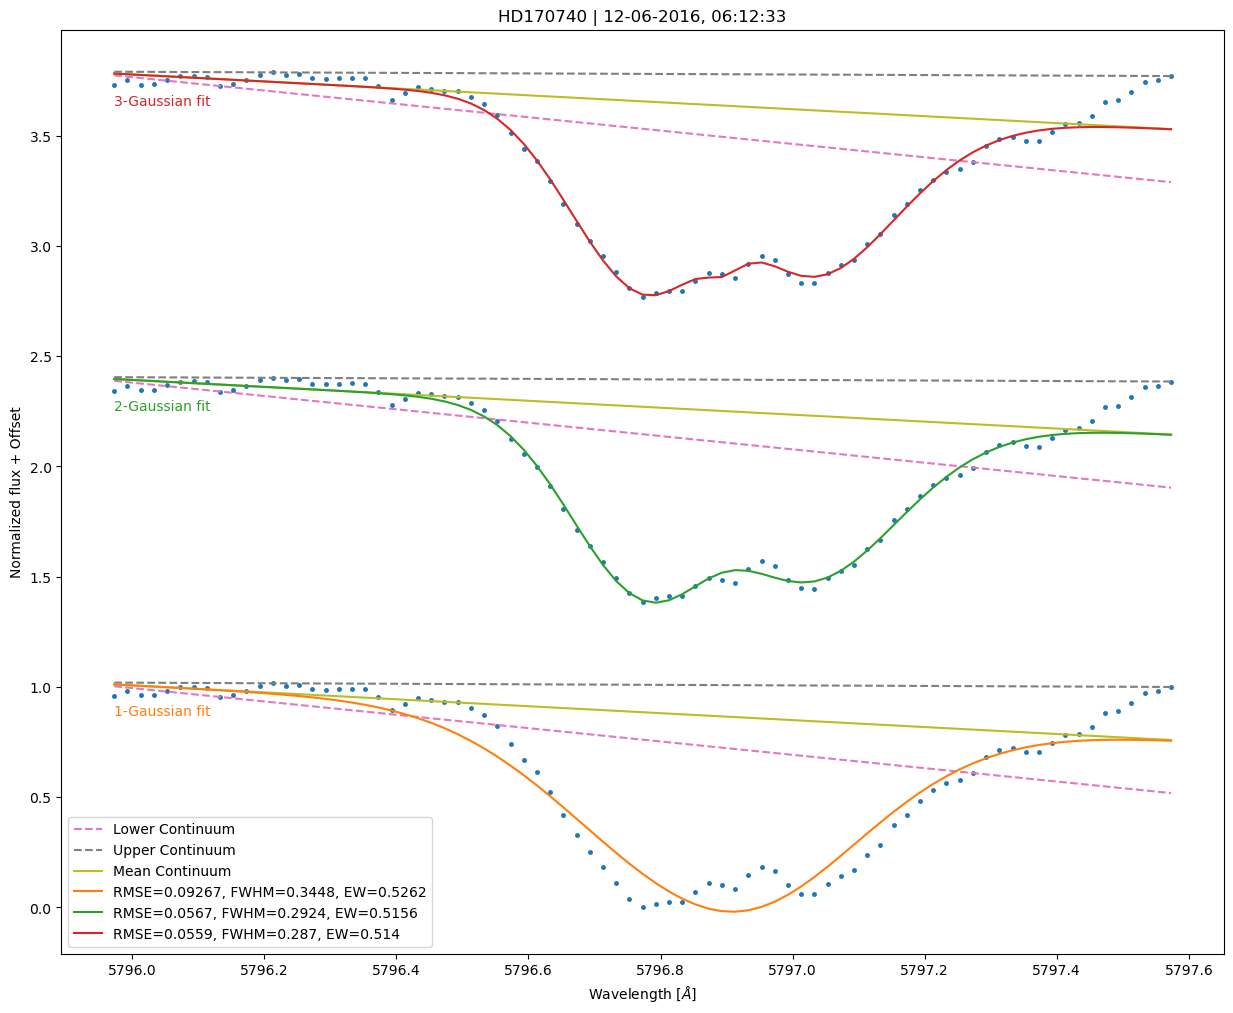

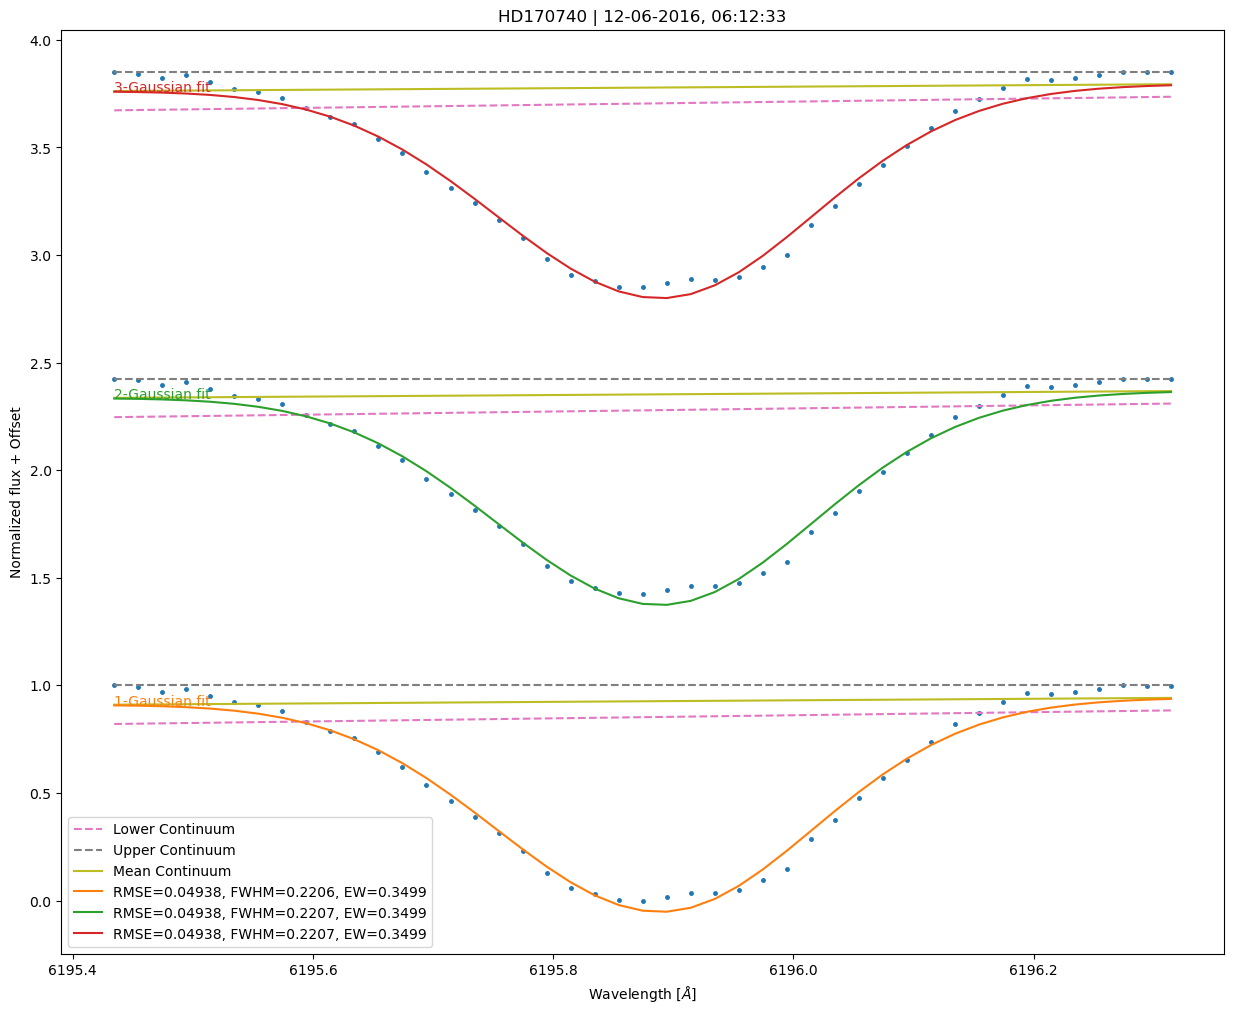

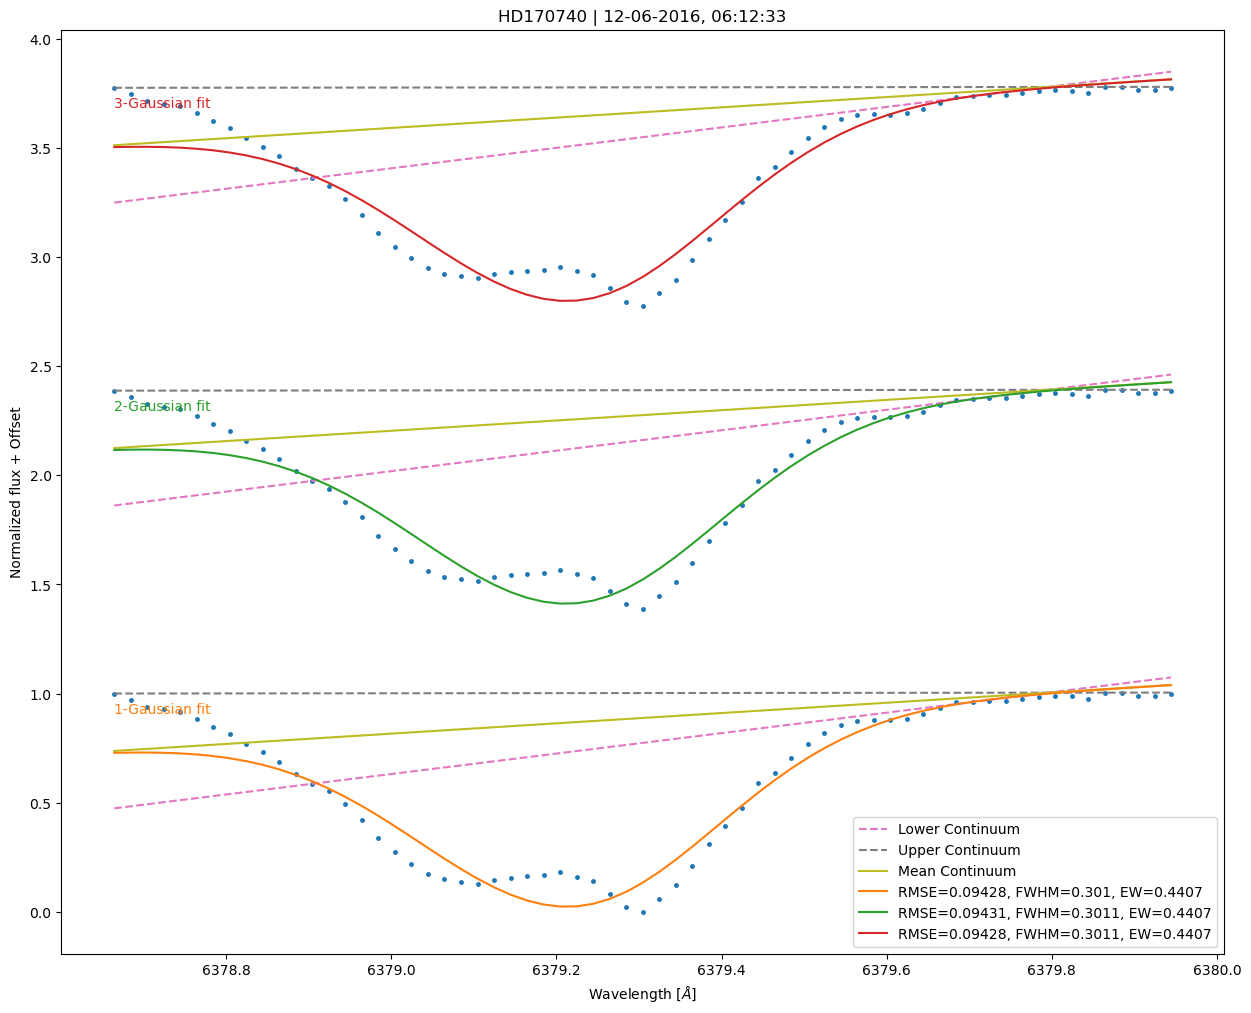

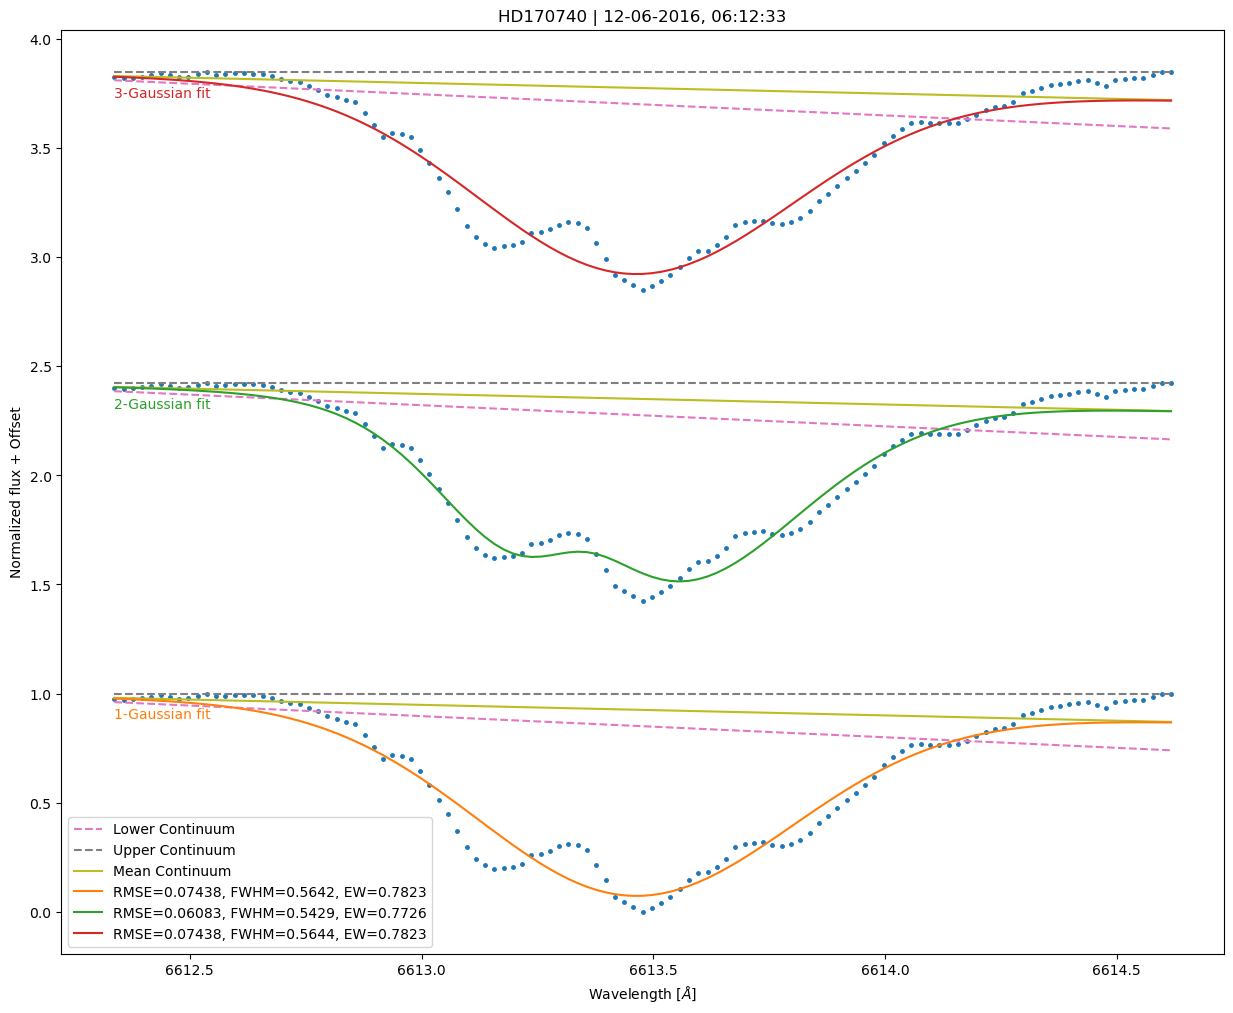

In [11]:
fit_gaussian_for_subspectrum(
    FitsSpectrum('data/fits/HD170740/RED_564/HD170740_w564_n9_20160612_U.fits'),
    expected_dib_centers=dib_centers_subset,
    create_figure=True,
    # show_error=True
)

In [ ]:
_ = fit_gaussian_for_targets('HD170740', expected_dib_centers=dib_centers_all, export=True)

λ=3732.12-4999.76 [4984.55]: 100%|██████████| 307/307 [00:01<00:00, 171.58it/s]
HD170740 | 26-06-2015, 02:26:04: 100%|██████████| 1/1 [01:29<00:00, 89.73s/it]


Target,Observation date,Start [Å],End [Å],Center [Å],Width,Amplitude,Skew,RMSE,FWHM [Å],EW [Å]
HD170740,"05-05-2016, 04:55:55",5703.68,5707.08,[5705.39307701],[0.73417044],[0.73359779],[0.20814667],0.114591,1.72884,1.72918
HD170740,"05-05-2016, 04:55:55",5765.69,5766.73,[5766.26883923 5766.16856936 5766.1718811 ],[0.06776789 0.04638851 1.95474458],[0.10311621 0.544728 0.29750613],[-1.99546195 -0.35374599 -0.05986358],0.173074,4.60307,0.458361
HD170740,"05-05-2016, 04:55:55",5780.45,5781.25,[5780.74746288 5780.74757052 5780.74746294],[0.06620186 0.60066766 0.14006631],[0.11716087 0.15908355 0.80391107],[ 1.99999274 1.58102526 -0.35309719],0.173677,1.41446,0.426285
HD170740,"05-05-2016, 04:55:55",5784.59,5785.23,[5784.88117403 5785.00810024 5784.88935155],[0.17166576 0.28288061 0.06303462],[0.12446747 0.25220995 0.67302393],[ 1.99297871 -2. -0.11655777],0.23268,0.666133,0.396272
HD170740,"05-05-2016, 04:55:55",5784.91,5785.55,[5785.17658129 5785.32815048 5785.32815048],[0.03740145 0.02651212 0.19877598],[0.23487672 0.10700972 0.07418223],[-1.99999772 -1.98643612 -1.99949771],0.429326,0.468082,0.157981
HD170740,"05-05-2016, 04:55:55",5796.29,5797.85,[5797.05458356 5797.11949489 5796.9700092 ],[0.07339244 0.17499803 1.02568638],[0.64175484 0.43761149 0.0215181 ],[ 0.12270225 -1.14082571 1.99996115],0.0415825,2.41531,0.598384
HD170740,"05-05-2016, 04:55:55",5844.8,5845.36,[5845.12993597 5845.00122631 5845.17754458],[0.08607538 0.08065992 0.23570716],[0.14044845 0.10339469 0.11988375],[ 1.99983054 -1.99733515 -2. ],0.120432,0.555048,0.248631
HD170740,"05-05-2016, 04:55:55",5849.24,5850.84,[5850.13832323 5850.13832322 5849.95659406],[0.15348438 0.49457281 0.07165138],[0.45552779 0.19268476 0.50262033],[-0.47789999 0.70255391 0.15679303],0.0930485,1.16463,0.68187
HD170740,"05-05-2016, 04:55:55",6019.2,6020.09,[6019.66177256 6019.64274106 6019.54500008],[0.01178657 0.07798542 0.14309978],[0.87209294 0.15234737 0.08427057],[0.4230409 1.99935671 1.98542684],0.215702,0.336974,0.245949
HD170740,"05-05-2016, 04:55:55",6058.69,6060.05,[6059.27118061 6059.27195565 6059.47110926],[0.14079892 1.3795682 0.34939796],[0.08270507 0.19267325 0.27100568],[-1.47677871 0.1715384 0.19146481],0.205414,3.24863,0.601422


In [8]:
_ = fit_gaussian_for_targets(['HD147889', 'HD158926', 'HD170740', 'HD185859'], expected_dib_centers=dib_centers_all, export=True)

λ=3732.08-4999.74 [4984.47]: 100%|██████████| 275/275 [00:02<00:00, 127.06it/s]
HD185859 | 13-08-2016, 03:32:39: 100%|██████████| 4/4 [03:37<00:00, 54.42s/it]


In [ ]:
fit_gaussian_for_targets(os.listdir('data/fits'), filename='gaussian_fits_all.csv')